# IS318 - Machine Learning

## TP1 - Linear regression  
## Authors : Elkarchi Jad & Wardi Mohamed Amine

The goal of this TP is to experiment with linear regression and polynomial linear regression.

First, we will work **without** the use of external libraries (such as `scikit-learn`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Dataset

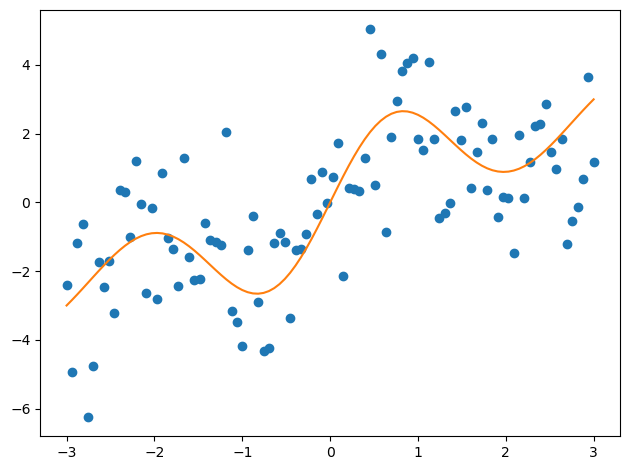

In [2]:
# Let us generate data points from a relatively complicated function
N = 100
alpha, sigma = 2., 3.
X = np.linspace(-3, 3, num=N)
y = X + (alpha * np.sin((2. * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))
# Add some random noise
rng = np.random.default_rng(42)
y_noisy = y + rng.standard_normal(N) * 2.
# Show the data points
plt.figure()
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.tight_layout()
plt.show()
plt.close()

**(Question)** Shuffle and split the dataset into training (75%) and validation (25%) sets. Store the results into variables `X_train`, `y_train`, `X_valid`, `y_valid`.

*Hint:* you can use `rng.permutation` to generate a random permutation of the points.

In [3]:
# shuffling
permutation_indices = rng.permutation(len(X))
X_shuffled = X[permutation_indices]
y_shuffled = y_noisy[permutation_indices]

# splitting
split_percentile = len(X_shuffled)*75//100
X_train, X_valid = X_shuffled[:split_percentile], X_shuffled[split_percentile:]
y_train, y_valid = y_shuffled[:split_percentile], y_shuffled[split_percentile:]

In [4]:
assert X_train.shape == (75,)
assert y_train.shape == (75,)
assert X_valid.shape == (25,)
assert y_valid.shape == (25,)
assert np.any(X_valid != X[75:]) # points should be shuffled

### 2. Linear regression in 1D

Recall the 1D linear regression model, where we search for parameters $w_0, w_1$ that will satisfy $y_i = w_0 + w_1 x_i$ (for all $i$ in the training set).

To simplify calculations, we usually set $\textbf{w} = [w_0, w_1]^T$ and $\textbf{x}_i = [1, x_i]^T$.

Then we have $y_i = \textbf{w}^T \textbf{x}_i $.

**(Question)** Add a column with ones to the points in `X_train` and `X_valid`. Store the result in new variables `X_train_ones` and `X_valid_ones`:

In [5]:
X_train_ones = np.column_stack((np.ones_like(X_train), X_train))
X_valid_ones = np.column_stack((np.ones_like(X_valid), X_valid))

X_train_ones.shape

(75, 2)

**(Question)** Use normal equations to find the parameters that minimize the mean squared error on the training set.

In [6]:
w = np.dot(np.dot(np.linalg.inv(np.dot(X_train_ones.T, X_train_ones)), X_train_ones.T), y_train)

# the weights solving the previous normal equation are :
w

array([-0.03550166,  0.68680383])

In [7]:
assert w.shape == (2,)

**(Question)** Plot the fitted line on top of the data points. Explain the result. (complete the code and answer in the cell below)

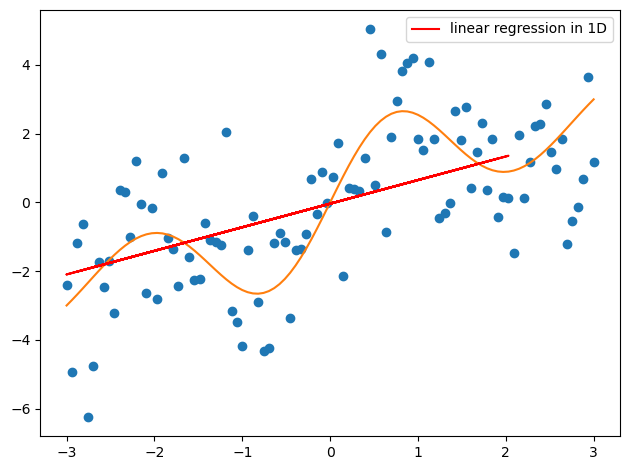

In [8]:
# Show the fitted line
plt.figure()
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.plot(X_valid, np.dot(w, X_valid_ones.T), color='red', label="linear regression in 1D")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## **Answer :** 
**The plot above show a straight line model that allow us the have a vague idea about the data distribution. Although it doesn't represent the data points accurately it does follow the distribution in 1D, which is something to be expected when using a 1 dimension normal equation.**

**(Question)** Plot the loss function landscape. What can you conclude from this visualization? (complete the code and answer in the cell below)

*Hint: the loss landscape can be represented by a 2D map (for example of size 100x100) where in each coordinate $(w_0, w_1)$ the value is mean squared error for these parameters. You can use `plt.contourf` to visualize the result.*

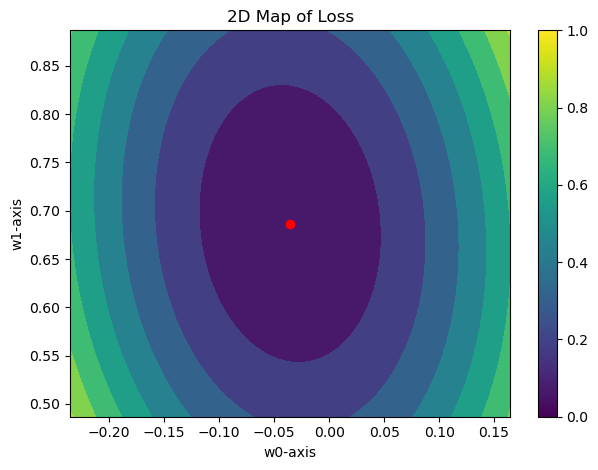

In [9]:
# we choose the following loss function (2D)
w0 = np.linspace(w[0]-0.2, w[0]+0.2, 100)
w1 = np.linspace(w[1]-0.2, w[1]+0.2, 100)
loss = np.empty((100, 100))

for i in range(100) :
    for j in range(100) :
        loss[i, j] = np.mean((y_train - np.dot(X_train_ones, np.array([w0[i], w1[j]])))**2)

assert loss.shape == (100, 100)

# Create a grid of points
X, Y = np.meshgrid(w0, w1)

# Create a contour plot
plt.figure()
plt.contourf(X, Y, loss, cmap='viridis')
plt.scatter(w[0], w[1], color="red")
plt.colorbar()
plt.xlabel('w0-axis')
plt.ylabel('w1-axis')
plt.title('2D Map of Loss')
plt.tight_layout()
plt.show()
plt.close()

## Answer :
As we can see from the 2D loss map, the calculated w (the red dot) parameter by minimizing the mean squared error is indeed in the minimal part of the Map

### 3. Polynomial linear regression

We move on the polynomial linear regression model with degree $D$, where the relationship between $y_i$ and $x_i$ is
$ y_i = w_0 + w_1x_i + w_2x_i^2 + \ldots + w_D x_i^D $

With $\textbf{w} = [w_0, \ldots, w_D]^T$ and $\textbf{x}_i = [1, x_i, x_i^2, \ldots, x_i^D]^T$, we have $y_i = \textbf{w}^T \textbf{x}_i $.

$D \geq 1$ is an hyperparameter of the model.

**(Question)** Complete the following `PolynomialRegression` class

In [10]:
class PolynomialRegression():
    def __init__(self, D=1):
        assert D >=1
        self.D = D
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        if not hasattr(self, 'w') :
            raise AttributeError("fit the model before predicting X")
        return np.dot(X, self.w)

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        return np.vander(X, self.D+1, increasing=True)

**(Question)** Implement the mean squared error function to measure the quality of predictions.

In [11]:
def mean_squared_error(y_true, y_pred):
    '''Return the mean squared error between `y_true` and `y_pred`.'''
    assert y_true.shape == y_pred.shape
    return np.mean((y_pred - y_true)**2)

In [12]:
a, b = np.random.randn(10), np.random.randn(10)
assert mean_squared_error(a, b) >= 0.
assert mean_squared_error(a, a) == 0.

**(Question)** Apply the polynomial regression model with $D=5$. Compute and print the mean squared error for the training and validation sets.

In [13]:
# YOUR CODE HERE
pr = PolynomialRegression(D=5)
X_poly_train, X_poly_valid = pr.make_poly(X_train), pr.make_poly(X_valid)
pr.fit(X_poly_train, y_train)
y_pred = pr.predict(X_poly_valid)
mse = mean_squared_error(y_valid, y_pred)
print(mse)

3.321513387311777


**(Question)** Plot the fitted polynomial curve on top of the data points. Explain the result. (complete the code and answer in the cell below)

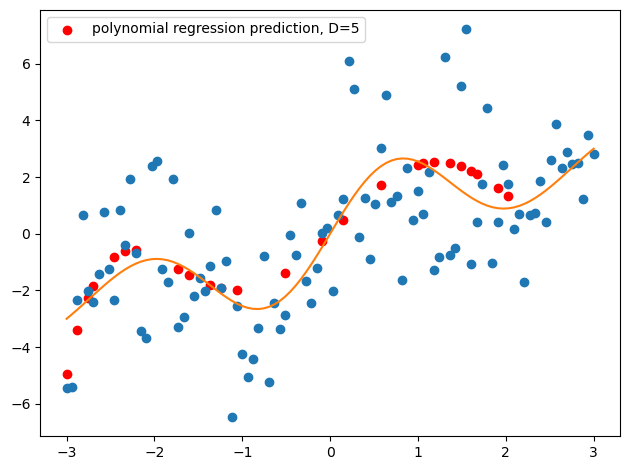

In [14]:
# YOUR CODE HERE
X = np.linspace(-3, 3, num=N)
y = X + (alpha * np.sin((2. * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))
# Add some random noise
y_noisy = y + rng.standard_normal(N) * 2.
plt.figure()
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.scatter(X_valid, y_pred, color='red', label="polynomial regression prediction, D=5")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


We have a more repsentative result with D = 5, as we can see from the figure it is closer to real reprsentation (in orange)

**(Question)** Using the validation set, implement a simple model selection strategy to optimize hyperparameter $D$ and print this value. For this question, you should limit the search to $D \in [1, 15]$.
To visualize potential underfitting and overfitting effects, plot the evolution of the error on the training and the validation sets for the different values of $D$.

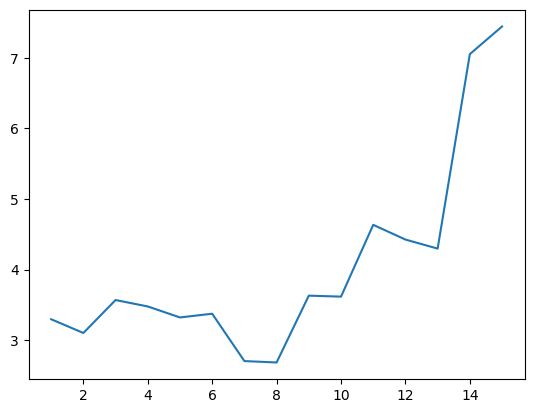

In [15]:
# YOUR CODE HERE
error_values = np.empty((15,))
for i in range(1, 16) :
    pr = PolynomialRegression(D=i)
    X_poly_train, X_poly_valid = pr.make_poly(X_train), pr.make_poly(X_valid)
    pr.fit(X_poly_train, y_train)
    y_pred = pr.predict(X_poly_valid)
    mse = mean_squared_error(y_valid, y_pred)
    error_values[i-1] = mse

plt.figure()
plt.plot(range(1, 16), error_values)
plt.show()
plt.close()

**(Question)** Plot the fitted polynomial curve of the best model on top of the data points. Comment the results.

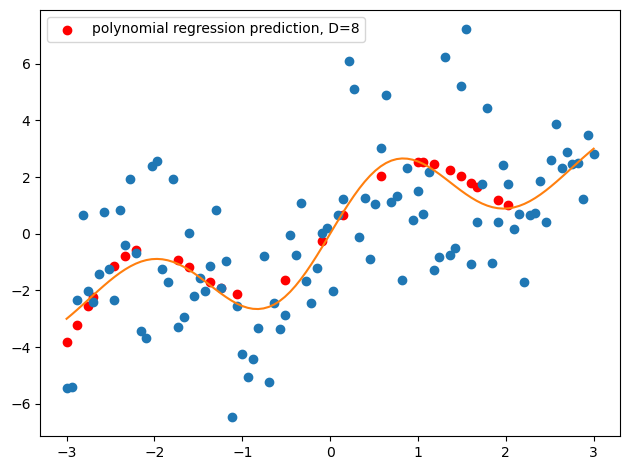

In [16]:
# YOUR CODE HERE
d_best = np.argmin(error_values) + 1

pr = PolynomialRegression(D=d_best)
X_poly_train, X_poly_valid = pr.make_poly(X_train), pr.make_poly(X_valid)
pr.fit(X_poly_train, y_train)
y_pred_best = pr.predict(X_poly_valid)

plt.figure()
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.scatter(X_valid, y_pred_best, color='red', label="polynomial regression prediction, D=8")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


It is follows the same behavior as the real representation and it is very close to it.

### 4. Regularized polynomial regression

Now, we want to implement polynomial regression with *weight decay* regularization:
$\hat{L}(\textbf{w}) = \frac{1}{N} \lVert \textbf{X} \textbf{w} - \textbf{y} \rVert^2 + \lambda \lVert\textbf{w}\rVert^2$

Here, $\lambda \geq 0$ is another hyperparameter of our model.

**(Question)** Complete the following `RegularizedPolynomialRegression` class.

In [17]:
class RegularizedPolynomialRegression():
    def __init__(self, D=1, lmbda=1.):
        assert D >=1 and lmbda >= 0.
        self.D = D
        self.lmbda = lmbda
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        # YOUR CODE HERE
        XtX = np.dot(X.T, X)
        self.w = np.dot(np.dot(np.linalg.inv(self.lmbda*np.eye(XtX.shape[0]) + XtX), X.T), y)
        
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        # YOUR CODE HERE
        if not hasattr(self, 'w') :
            raise AttributeError("fit the model before predicting X")
        return np.dot(X, self.w)

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        return np.vander(X, self.D+1, increasing=True)

**(Question)** Apply regularized linear regression and play around with hyperparameters $D$ and $\lambda$. Plot the result.

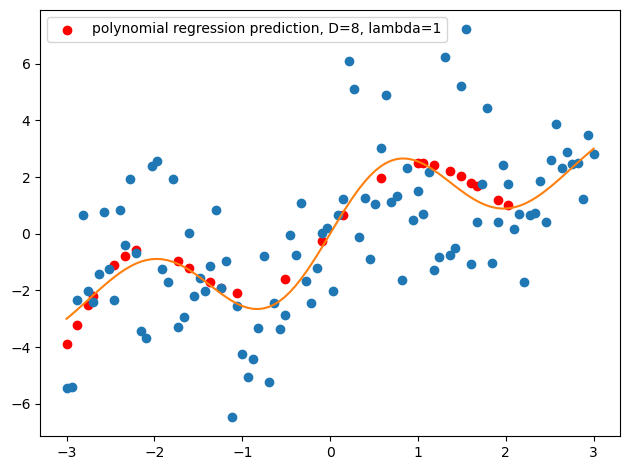

In [18]:
# STILL NEED TO PLAY AROUND THE PARAMETERS
rpr = RegularizedPolynomialRegression(D=8, lmbda=0.1)
X_poly_train, X_poly_valid = rpr.make_poly(X_train), rpr.make_poly(X_valid)
rpr.fit(X_poly_train, y_train)
y_pred = rpr.predict(X_poly_valid)

plt.figure()
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.scatter(X_valid, y_pred, color='red', label="polynomial regression prediction, D=8, lambda=1")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

### 5. Comparison with `sklearn`

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

**(Question)** Use the `sklearn` classes imported above to apply polynomial regression on our toy dataset. Compare the results with your implementation and comment.

In [20]:
# applying LinearRegression
linreg = LinearRegression()
linreg = linreg.fit(X_train.reshape(-1, 1), y_train)
y_pred_linreg = linreg.predict(X_valid.reshape(-1, 1))
print("mse Linear Regression: ", mean_squared_error(y_pred_linreg, y_valid))

mse Linear Regression:  3.2962739129409333


In [21]:
# applying Ridge
ridge = Ridge()
ridge = ridge.fit(X_train.reshape(-1, 1), y_train)
y_pred_ridge = ridge.predict(X_valid.reshape(-1, 1))
print("mse Ridge : ", mean_squared_error(y_pred_ridge, y_valid))

mse Ridge :  3.3007050723459104


In [22]:
# simple use for PolynomialFeatures instead of np.vander
poly = PolynomialFeatures(degree=2)

# Transform the feature matrix
X_poly = poly.fit_transform(np.array([1, 2, 3]).reshape(-1, 1))
X_poly

array([[1., 1., 1.],
       [1., 2., 4.],
       [1., 3., 9.]])